In [12]:
%config Completer.use_jedi = False
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [13]:
import os, pickle
import qose as qose
import networkx as nx
import operator
import pennylane as qml
from pennylane import numpy as np

In [14]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
def plot_variable_tree(G, **kwargs):
    labels = kwargs.pop('labels', True)
    ns = kwargs.pop('node_size', 25)
    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(kwargs.get('width',16), kwargs.get('height',10))
    pos = graphviz_layout(G, prog='dot')
    colors = nx.get_node_attributes(G, 'W')
    node_color = list(colors.values())
    vmin = min(node_color)
    vmax = max(node_color)
    nx.draw(G, pos=pos, arrows=True, with_labels=labels, cmap='OrRd', node_color=node_color, node_size=ns,linewidths=1,
            vmin=vmin, vmax=vmax, ax=axs)
    axs.collections[0].set_edgecolor("#000000")

    #sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))

    #cb = plt.colorbar(sm)
    #cb.set_label('W-cost',fontsize=kwargs.pop('fs_bar',16))
    #axs.set_title('Tree of costs',fontsize=kwargs.pop('fs_title',16))
    plt.show()

In [132]:
def make_predictions(circuit,pre_trained_vals,X,Y,**kwargs):

    if kwargs['readout_layer']=='one_hot':
        var = pre_trained_vals
        
    elif kwargs['readout_layer']=="weighted_neuron":
        var = pre_trained_vals
        
    # make final predictions
    if kwargs['readout_layer']=='one_hot':
        final_predictions = np.stack([circuit(var, x) for x in X])
        acc=qose.train_utils.ohe_accuracy(Y,predictions)
        
    elif kwargs['readout_layer']=='weighted_neuron':
        from autograd.numpy import exp
        n = kwargs.get('nqubits')
        w = var[:,-1]
        theta = var[:,:-1].numpy()
        final_predictions = [int(np.round(2.*(1.0/(1.0+exp(np.dot(-w,circuit(theta, features=x)))))- 1.,1)) for x in X]
        acc=qose.train_utils.wn_accuracy(Y,predictions)
        
    return final_predictions,acc
    

In [134]:
def train_best(circuit, pre_trained_vals,X_train, Y_train, batch_size, learning_rate,**kwargs):
    """
    train a circuit classifier
    Args:
        circuit (qml.QNode): A circuit that you want to train
        parameter_shape: A tuple describing the shape of the parameters. The first entry is the number of qubits,
        the second one is the number of layers in the circuit architecture.
        X_train (np.ndarray): An array of floats of size (M, n) to be used as training data.
        Y_train (np.ndarray): An array of size (M,) which are the categorical labels
            associated to the training data.

        batch_size (int): Batch size for the circuit training.

        learning_rate (float): The learning rate/step size of the optimizer.

        kwargs: Hyperparameters for the training (passed as keyword arguments). There are the following hyperparameters:

            nsteps (int) : Number of training steps.

            optim (pennylane.optimize instance): Optimizer used during the training of the circuit.
                Pass as qml.OptimizerName.

            Tmax (list): Maximum point T as defined in https://arxiv.org/abs/2010.08512. (Definition 8)
                    The first element is the maximum number of parameters among all architectures,
                    the second is the maximum inference time among all architectures in terms of computing time,
                    the third one is the maximum inference time among all architectures in terms of the number of CNOTS
                    in the circuit

            rate_type (string): Determines the type of error rate in the W-coefficient.
                    If rate_type == 'accuracy', the inference time of the circuit
                    is equal to the time it takes to evaluate the accuracy of the trained circuit with
                    respect to a validation batch three times the size of the training batch size and
                    the error rate is equal to 1-accuracy (w.r.t. to a validation batch).

                    If rate_type == 'accuracy', the inference time of the circuit is equal to the time
                    it takes to train the circuit (for nsteps training steps) and compute the cost at
                    each step and the error rate is equal to the cost after nsteps training steps.

    Returns:
        (Yprime,acc): final predictions, final accuracy
    """
    from autograd.numpy import exp
    def ohe_cost_fcn(params, circuit, ang_array, actual):
        '''
        use MAE to start
        '''
        predictions = (np.stack([circuit(params, x) for x in ang_array]) + 1) * 0.5
        return qose.train_utils.mse(actual, predictions)

    def wn_cost_fcn(params, circuit, ang_array, actual):
        '''
        use MAE to start
        '''
        w = params[:,-1]

        theta = params[:,:-1]
        print(w.shape,w,theta.shape,theta)
        predictions = np.asarray([2.*(1.0/(1.0+exp(np.dot(-w,circuit(theta,x)))))- 1. for x in ang_array])
        return qose.train_utils.mse(actual, predictions)

    if kwargs['readout_layer']=='one_hot':
        var = pre_trained_vals
    elif kwargs['readout_layer']=="weighted_neuron":
        var = pre_trained_vals
    rate_type = kwargs['rate_type']
    optim = kwargs['optim']
    num_train = len(Y_train)
    validation_size = int(0.1*num_train)
    opt = optim(stepsize=learning_rate) #all optimizers in autograd module take in argument stepsize, so this works for all

    for _ in range(kwargs['nsteps']):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        X_train_batch = np.asarray(X_train[batch_index])
        Y_train_batch = np.asarray(Y_train[batch_index])
        
        if kwargs['readout_layer']=='one_hot':
            var, cost = opt.step_and_cost(lambda v: ohe_cost_fcn(v, circuit, X_train_batch, Y_train_batch), var)
        elif kwargs['readout_layer']=='weighted_neuron':
            print(var)
            var, cost = opt.step_and_cost(lambda v: wn_cost_fcn(v, circuit, X_train_batch, Y_train_batch), var)
        print(_,cost)
        # check for early stopping
        if _%5==0:
            validation_batch = np.random.randint(0, num_train, (validation_size,))
            X_validation_batch = np.asarray(X_train[validation_batch])
            Y_validation_batch = np.asarray(Y_train[validation_batch])
            if kwargs['rate_type'] == 'accuracy':
                if kwargs['readout_layer']=='one_hot':
                    predictions = np.stack([circuit(var, x) for x in X_validation_batch])
                    acc=qose.train_utils.ohe_accuracy(Y_validation_batch,predictions)
                elif kwargs['readout_layer']=='weighted_neuron':
                    n = kwargs.get('nqubits')
                    w = var[:,-1]
                    theta = var[:,:-1].numpy()
                    predictions = [int(np.round(2.*(1.0/(1.0+exp(np.dot(-w,circuit(theta, x)))))- 1.,1)) for x in X_validation_batch]
                    acc=qose.train_utils.wn_accuracy(Y_validation_batch,predictions)
                if acc>0.95:
                    break

            elif kwargs['rate_type'] == 'batch_cost':
                if cost < 0.001:
                    break
    # make final predictions
    if kwargs['readout_layer']=='one_hot':
        final_predictions = np.stack([circuit(var, x) for x in X_train])
    elif kwargs['readout_layer']=='weighted_neuron':
        n = kwargs.get('nqubits')
        w = var[:,-1]
        theta = var[:,:-1]
        final_predictions = [int(np.round(2.*(1.0/(1.0+exp(np.dot(-w,circuit(theta, x)))))- 1.,1)) for x in X_train]
    return var,final_predictions


In [135]:
data_path = 'dummy'

In [136]:
# Create a configuration file for the tree prune algorithm
config = {'nqubits': 4,
          'min_tree_depth': 6,
          'max_tree_depth': 10,
          'prune_rate': 0.2,
          'prune_step': 4,
          'plot_trees': False,
          'data_set': 'moons',
          'nsteps': 30, # this is higher for post-training
          'optim': qml.AdamOptimizer,
          'batch_sizes': [16,32],
          'n_samples': 1000,
          'learning_rates': [0.005,0.01],
          'save_frequency': 1,
          'save_path': data_path,
          'save_timing': True,
          'circuit_type':'schuld',
          'Tmax': [100,100,100],
          'inf_time':'timeit',
          'fill':'redundant', # or 'pad'
          'rate_type': 'accuracy', # or 'batch_cost'
          'readout_layer': 'weighted_neuron',  #or 'weighted_neuron'
          }


dev = qml.device("default.qubit", wires=config['nqubits'])

In [137]:
from sklearn import datasets
if config['data_set'] == 'circles':
    X_train, y_train = datasets.make_circles(n_samples=config['n_samples'], factor=.5, noise=.05)
elif config['data_set'] == 'moons':
    X_train, y_train = datasets.make_moons(n_samples=config['n_samples'], noise=.05)
# rescale data to -1 1
X_train = np.multiply(1.0, np.subtract(np.multiply(np.divide(np.subtract(X_train, X_train.min()),
                                                             (X_train.max() - X_train.min())), 2.0), 1.0))

if config['readout_layer'] == 'one_hot':
    # one hot encode labels
    # y_train_ohe = np.zeros((y_train.size, y_train.max() + 1))
    y_train_ohe = np.zeros((y_train.size, config['nqubits']))
    y_train_ohe[np.arange(y_train.size), y_train] = 1
elif config['readout_layer'] == 'weighted_neuron':
    y_train_ohe = y_train
    
n_classes = len(np.unique(y_train).numpy())

In [138]:
n_classes

2

## Read in earlier data

In [139]:
os.chdir('/Users/kathleenhamilton/QHACK2021/data')
os.chdir('WN_4Q_moonss/')
G = nx.read_gpickle('tree_depth_5.pickle')
best_arch = max(nx.get_node_attributes(G,'W').items(), key=operator.itemgetter(1))[0]
print('architecture with max W: ',best_arch)
print('max W:', G.nodes[best_arch]['W'])
print('weights: ',G.nodes[best_arch]['weights'])

architecture with max W:  E1:Y:X:hw_CNOT
max W: 8.804681067722136
weights:  [[-0.06986818 -0.06791047  0.          0.42013008]
 [ 0.94114494  0.90390821  0.          0.76461822]
 [-0.7527752  -0.04451544  0.          1.2495264 ]
 [-0.64925175  0.12101633  0.          0.53460633]]


### look at the last saved tree, extract the best architecture

In [140]:
G = nx.read_gpickle('tree_depth_5.pickle')
best_arch = max(nx.get_node_attributes(G,'W').items(), key=operator.itemgetter(1))[0]
print('architecture with max W: ',best_arch)
print('max W:', G.nodes[best_arch]['W'])
print('weights: ',G.nodes[best_arch]['weights'])

architecture with max W:  E1:Y:X:hw_CNOT
max W: 8.804681067722136
weights:  [[-0.06986818 -0.06791047  0.          0.42013008]
 [ 0.94114494  0.90390821  0.          0.76461822]
 [-0.7527752  -0.04451544  0.          1.2495264 ]
 [-0.64925175  0.12101633  0.          0.53460633]]


#### convert best architecture to circuit and do additional training

In [141]:
best_circuit = qose.subarchitecture_tree_search.construct_circuit_from_leaf(best_arch,config['nqubits'],n_classes,dev,config)[0]
pre_trained_weights = G.nodes[best_arch]['weights']

In [142]:
pre_trained_weights

array([[-0.06986818, -0.06791047,  0.        ,  0.42013008],
       [ 0.94114494,  0.90390821,  0.        ,  0.76461822],
       [-0.7527752 , -0.04451544,  0.        ,  1.2495264 ],
       [-0.64925175,  0.12101633,  0.        ,  0.53460633]])

In [143]:
train_best(best_circuit,pre_trained_weights,X_train,y_train_ohe, 32, 0.2,**config)

[[-0.06986818 -0.06791047  0.          0.42013008]
 [ 0.94114494  0.90390821  0.          0.76461822]
 [-0.7527752  -0.04451544  0.          1.2495264 ]
 [-0.64925175  0.12101633  0.          0.53460633]]
(4,) Autograd ArrayBox with value [0.42013008 0.76461822 1.2495264  0.53460633] (4, 3) Autograd ArrayBox with value [[-0.06986818 -0.06791047  0.        ]
 [ 0.94114494  0.90390821  0.        ]
 [-0.7527752  -0.04451544  0.        ]
 [-0.64925175  0.12101633  0.        ]]


AttributeError: 'tensor' object has no attribute 'idx'

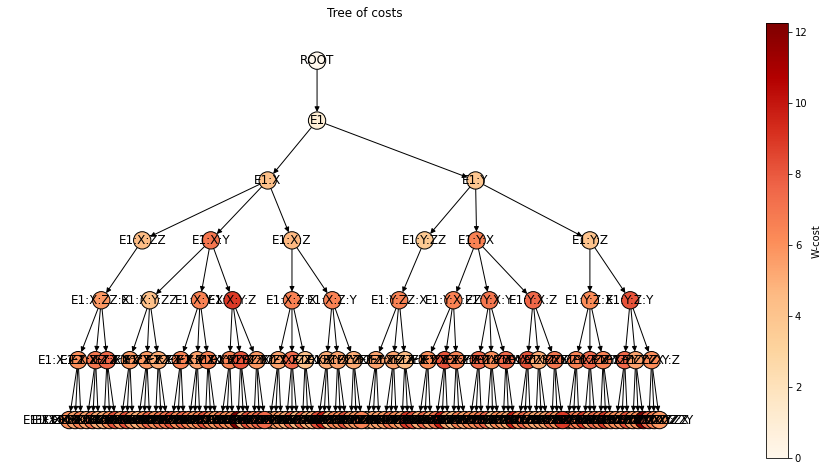

In [12]:
qose.plot_tree(G)

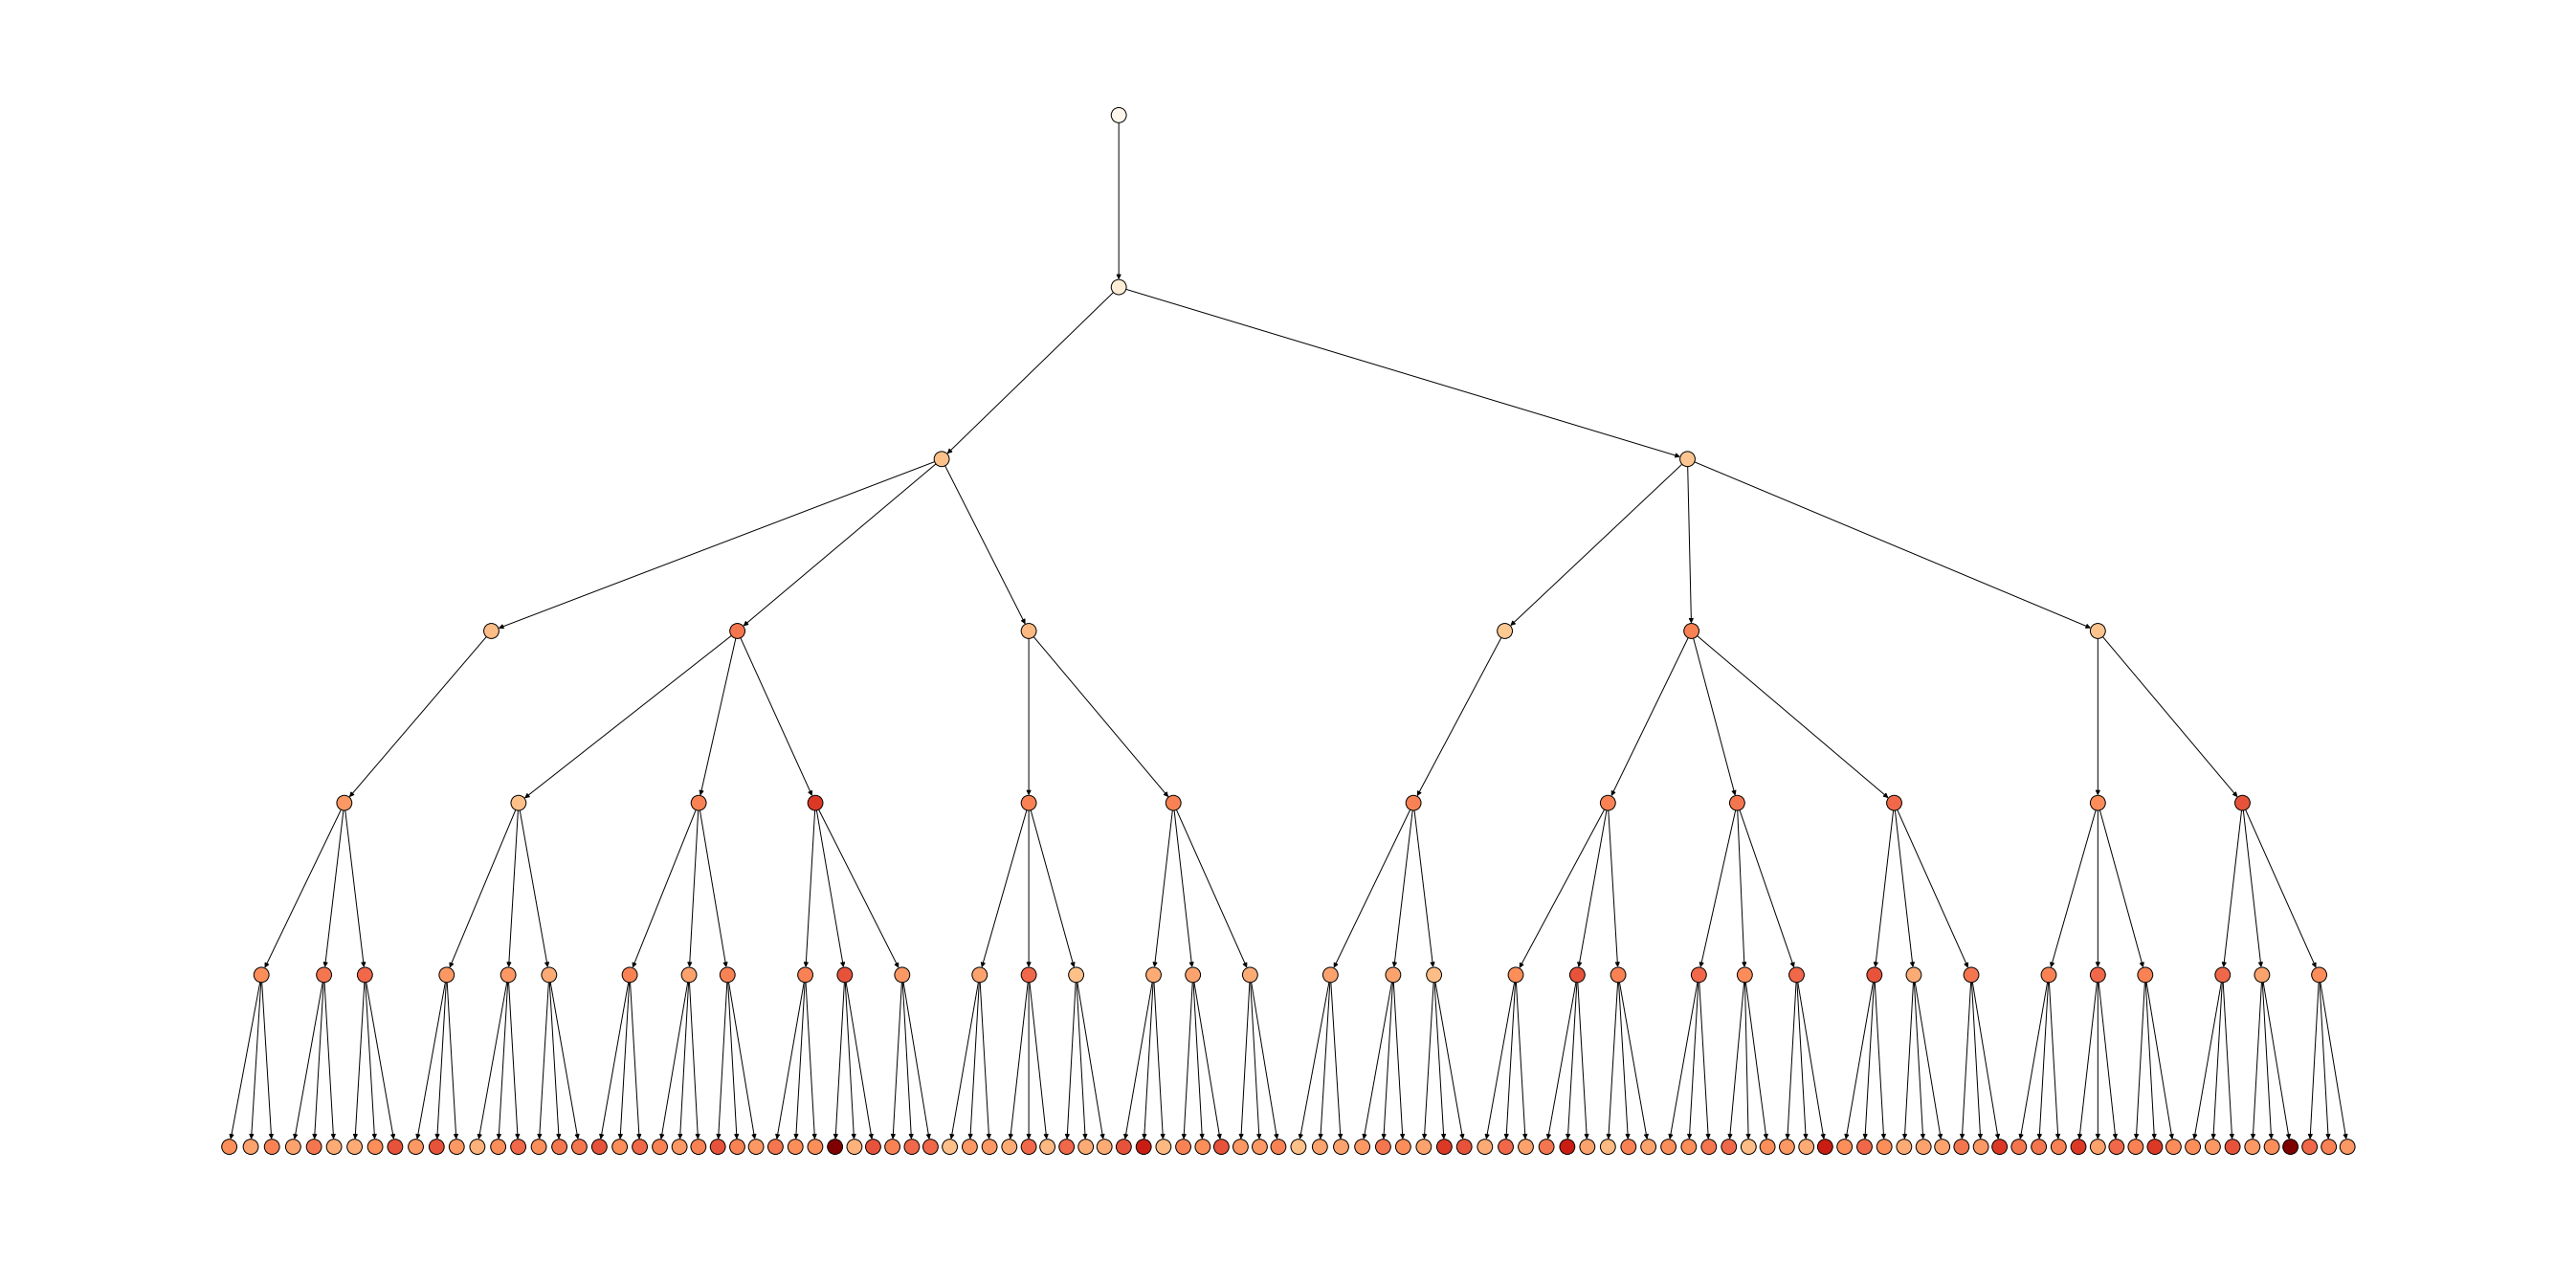

In [39]:
plot_variable_tree(G,width=48,height=24,labels=False,node_size=250,fs_bar=24,fs_title=24)

## Run the search

In [3]:
# Create a unique name for your experiment
EXPERIMENT_NAME = 'one_hot'

# Create a directory to store the data
if not os.path.exists('data'):
    os.mkdir('data/')

data_path = f'data/{EXPERIMENT_NAME}'
if not os.path.exists(data_path):
    os.mkdir(data_path)

# Create a configuration file for the tree prune algorithm
config = {'nqubits': 2,
          'min_tree_depth': 6,
          'max_tree_depth': 10,
          'prune_rate': 0.2,
          'prune_step': 4,
          'plot_trees': False,
          'data_set': 'moons',
          'nsteps': 5,
          'optim': qml.AdamOptimizer,
          'batch_sizes': [16,32],
          'n_samples': 1500,
          'learning_rates': [0.005,0.01],
          'save_frequency': 1,
          'save_path': data_path,
          'save_timing': True,
          'circuit_type':'schuld',
          'Tmax': [100,100,100],
          'inf_time':'timeit',
          'fill':'redundant', # or 'pad'
          'rate_type': 'accuracy', # or 'batch_cost'
          'readout_layer': 'one_hot',  #or 'weighted_neuron'
          }

# Save the configuration file so that we can remember what we did
with open(data_path + '/config.pickle', 'wb') as f:
    pickle.dump(config, f)

# Execute the algorithm
qose.run_tree_architecture_search(config,dev_type='local')



saving timing info
Depth = 1
Depth = 2
Current best architecture:  E1
max W: 1.0
weights: []
Training leaf E1:ZZ
Training leaf E1:X
Training leaf E1:Y
Training leaf E1:Z
Depth = 3
Current best architecture:  E1:X
max W: 1.7293626035132486
weights: [[0.03570652]
 [0.03403852]]
Training leaf E1:ZZ:X
Training leaf E1:ZZ:Y
Training leaf E1:ZZ:Z
Training leaf E1:X:ZZ
Training leaf E1:X:Y
Training leaf E1:X:Z
Training leaf E1:Y:ZZ
Training leaf E1:Y:X
Training leaf E1:Y:Z
Training leaf E1:Z:ZZ
Training leaf E1:Z:X
Training leaf E1:Z:Y
Depth = 4
Current best architecture:  E1:ZZ:Y
max W: 1.909010395700439
weights: [[0.01620665 0.01709944]
 [0.01620665 0.01593824]]
Training leaf E1:ZZ:X:ZZ
Training leaf E1:ZZ:X:Y
Training leaf E1:ZZ:X:Z
Training leaf E1:ZZ:Y:ZZ
Training leaf E1:ZZ:Y:X
Training leaf E1:ZZ:Y:Z
Training leaf E1:ZZ:Z:ZZ
Training leaf E1:ZZ:Z:X
Training leaf E1:ZZ:Z:Y
Training leaf E1:X:ZZ:X
Training leaf E1:X:ZZ:Y
Training leaf E1:X:ZZ:Z
Training leaf E1:X:Y:ZZ
Training leaf E1:X:

KeyboardInterrupt: 